In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
%matplotlib inline
from utils import preprocess

In [23]:
import numpy as np
import pandas as pd
import os

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [25]:
from keras.models import Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import Input

In [6]:
DATA_PATH = os.path.join('../data')
TRAIN_FILE = os.path.join(DATA_PATH, 'train.csv')
TEST_FILE = os.path.join(DATA_PATH, 'test.csv')

In [26]:
train_features = preprocess(TRAIN_FILE)

In [27]:
train_features.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'quarter', u'weekday',
       u'holiday', u'st_dist', u'h_dist', u'travel_dir', u'bearing',
       u's_pickup_latitude', u's_pickup_longitude', u's_dropoff_latitude',
       u's_dropoff_longitude', u'flag', u'month_end', u'month_start'],
      dtype='object')

In [28]:
X = train_features[[u'vendor_id',
       u'passenger_count', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_mon', u'weekday',
       u'holiday', u'st_dist', u'h_dist', u'bearing',
       u's_pickup_latitude', u's_pickup_longitude', u's_dropoff_latitude',
       u's_dropoff_longitude', u'flag', u'month_end', u'month_start']].as_matrix()
y = train_features['trip_duration']

In [29]:
print X.shape
print y.shape

(1458644, 19)
(1458644,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [94]:
from keras.optimizers import Adam, RMSprop

In [32]:
from keras.layers import BatchNormalization

In [33]:
from keras import backend as K
def root_mean_squared_logarithmic_error(y_true, y_pred):
    #y_pred = K.round(y_pred)
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log)))

rmsle = root_mean_squared_logarithmic_error

In [91]:
learning_rate = 0.0001

In [101]:
_input = Input(shape=(19,))
#_norm = BatchNormalization()(_input)
layer1 = Dense(100, activation='linear')(_input)
layer2 = Dense(20, activation='relu')(layer1)
_output = Dense(1, activation='relu')(layer2)

model = Model(inputs=[_input], outputs=[_output])
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer,
             loss=rmsle)

In [117]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

checkpoint = ModelCheckpoint('weights1.h5', save_best_only=True,
                             monitor='val_loss', verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
              patience=10, verbose=1)

def scheduler(epoch):
    if epoch < 40:
        return learning_rate
    if epoch > 40 and epoch < 80:
        return learning_rate * 0.1
    else:
        return learning_rate * 0.05
    
lr_scheduler = LearningRateScheduler(scheduler)
results = model.fit(X_train, y_train, 
                    batch_size=1024,
                    epochs=100, callbacks=[checkpoint],
                    validation_split=0.2)

Train on 933532 samples, validate on 233383 samples
Epoch 1/100
933532/933532 [==============================] - 4s - loss: 0.5046 - val_loss: 0.5025
Epoch 2/100
933532/933532 [==============================] - 4s - loss: 0.5045 - val_loss: 0.5013
Epoch 3/100
933532/933532 [==============================] - 4s - loss: 0.5043 - val_loss: 0.5011
Epoch 4/100
933532/933532 [==============================] - 4s - loss: 0.5041 - val_loss: 0.5011
Epoch 5/100
933532/933532 [==============================] - 4s - loss: 0.5039 - val_loss: 0.5013
Epoch 6/100
933532/933532 [==============================] - 4s - loss: 0.5034 - val_loss: 0.5003
Epoch 7/100
933532/933532 [==============================] - 3s - loss: 0.5031 - val_loss: 0.5005
Epoch 8/100
933532/933532 [==============================] - 4s - loss: 0.5033 - val_loss: 0.5017
Epoch 9/100
933532/933532 [==============================] - 4s - loss: 0.5030 - val_loss: 0.5012
Epoch 10/100
933532/933532 [==============================] - 3s -

933532/933532 [==============================] - 4s - loss: 0.4975 - val_loss: 0.4935
Epoch 84/100
933532/933532 [==============================] - 4s - loss: 0.4965 - val_loss: 0.4922
Epoch 85/100
933532/933532 [==============================] - 4s - loss: 0.4954 - val_loss: 0.4930
Epoch 86/100
933532/933532 [==============================] - 4s - loss: 0.4968 - val_loss: 0.4927
Epoch 87/100
933532/933532 [==============================] - 4s - loss: 0.4956 - val_loss: 0.4933
Epoch 88/100
933532/933532 [==============================] - 4s - loss: 0.4954 - val_loss: 0.4926
Epoch 89/100
933532/933532 [==============================] - 4s - loss: 0.4955 - val_loss: 0.4941
Epoch 90/100
933532/933532 [==============================] - 4s - loss: 0.4960 - val_loss: 0.4918
Epoch 91/100
933532/933532 [==============================] - 4s - loss: 0.4962 - val_loss: 0.4927
Epoch 92/100
933532/933532 [==============================] - 4s - loss: 0.4953 - val_loss: 0.4919
Epoch 93/100
933532/933

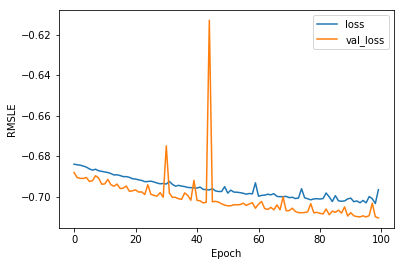

In [118]:
from matplotlib import pyplot as plt
plt.plot(results.epoch, np.log(results.history['loss']), label='loss')
plt.plot(results.epoch, np.log(results.history['val_loss']), label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.legend()
plt.show()

In [119]:
model.load_weights('weights1.h5')

In [120]:
y_test_hat = model.predict(X_test)
print 'Test MSE: {}'.format(mean_squared_error(y_test, y_test_hat))

Test MSE: 52338009.9163


In [121]:
test_loss = []
for yt, yth in zip(y_test, y_test_hat):
    diff = np.log(yt + 1.) - np.log(yth + 1.)
    test_loss.append(diff ** 2)
print np.sqrt(np.mean(test_loss))

0.494549


In [122]:
np.min(y_test_hat)

13.155119

In [108]:
test_features = preprocess(TEST_FILE)

In [109]:
test_ = test_features[[u'vendor_id',
       u'passenger_count', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_mon', u'weekday',
       u'holiday', u'st_dist', u'h_dist', u'bearing',
       u's_pickup_latitude', u's_pickup_longitude', u's_dropoff_latitude',
       u's_dropoff_longitude', u'flag', u'month_end', u'month_start']]

In [123]:
pred = model.predict(test_.as_matrix())
print pred.shape

(625134, 1)


In [124]:
with open('predictions.txt', 'w') as _file:
    _file.write('id,trip_duration\n')
    for tid, p in zip(test_features['id'], pred):
        # tid, pred = example[0], model.predict(np.array([example[1:]]))
        p = p[0]
        _file.write('{},{}\n'.format(tid, p))

In [125]:
!wc -l predictions.txt

  625135 predictions.txt


In [126]:
p = pd.read_csv('predictions.txt')

In [127]:
p.describe()

,trip_duration
count,625134.000000
mean,836.761949
std,620.689115
min,16.102797
25%,472.282776
50%,666.010925
75%,979.394958
max,124920.398438


In [128]:
z = pd.DataFrame(y_train)

In [129]:
z.describe()

,trip_duration
count,1.166915e+06
mean,9.585794e+02
std,4.597865e+03
min,1.000000e+00
25%,3.970000e+02
50%,6.630000e+02
75%,1.075000e+03
max,2.227612e+06
